# Importações

In [1]:
#!pip install scikit-learn shap pandas numpy matplotlib xgboost seaborn 

In [ ]:
import pickle

import shap
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np  

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# Transformadores personalizados
from transformers import DateFeatureExtractor, CapTransformer, RareCategoryGrouper, TopNMultiLabelTransformer

# Carregando dataset

In [ ]:
df = pd.read_csv('../data/filmes_filtrados_credits.csv')

# Dividindo os dados
- X_train, X_test, y_train, y_test

In [ ]:
numerical_cols = df[['popularity', 'budget', 'runtime']].columns
categorical_col = ['original_language']
date_column = 'release_date'

X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# Transformadores
- MultiLabelBinarize -> Generos Cinematográficos, Produtora e Atores
- Data -> Extrai o ano e o mês das datas
- Outliers -> Cap, Log + Cap, Winsorizer
- Agrupamento de categorias raras -> original language

In [ ]:
# Transformers personalizados por coluna
credits_transformer = TopNMultiLabelTransformer(top_n=60, prefix='credits')
genres_transformer = TopNMultiLabelTransformer(top_n=20, prefix='genre')
prod_companies_transformer = TopNMultiLabelTransformer(top_n=60, prefix='prod_company')

# Treinamento
- Modelo XGBRegressor
- Modelo SVR
- Modelo RandomForest

### Definindo Kf

In [ ]:
# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

### XGBRegressor

In [ ]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico (ex: original_language)
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento geral com ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')  # passar colunas extras como ano/mês se já forem numéricas


pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=87, n_jobs=-1))
])

param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}


XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

XGBRegressor_rand.fit(X_train, y_train)

print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'regressor__colsample_bytree': np.float64(0.7031696296554636), 'regressor__learning_rate': np.float64(0.06583175816091916), 'regressor__max_depth': 7, 'regressor__n_estimators': 131, 'regressor__subsample': np.float64(0.8020753990507417)}
Melhor R² (validação cruzada): 0.4956744938107381


### SVR

In [ ]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento completo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')  # mantém outras colunas (ex: year, month)



pipeline_svr = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist_svr = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}

svm_rand = RandomizedSearchCV(
    estimator=pipeline_svr,
    param_distributions=param_dist_svr,
    n_iter=20,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)
print("Melhores parâmetros SVR:", svm_rand.best_params_)
print("Melhor R² (CV) SVR:", svm_rand.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'credits'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\utils\_indexing.py", line 431, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3819, in get_loc
    raise KeyError(key) from err
KeyError: 'credits'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\pipeline.py", line 653, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\pipeline.py", line 587, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\pipeline.py", line 1539, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 988, in fit_transform
    self._validate_column_callables(X)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 541, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\sklearn\utils\_indexing.py", line 439, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


### RandomForest

In [ ]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento completo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')  # mantém outras colunas (ex: year, month)

pipeline_rf = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=87, n_jobs=-1))
])

param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=kf,
    scoring='r2',
    error_score='raise',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

rf_rand.fit(X_train, y_train)
print("Melhores parâmetros RF:", rf_rand.best_params_)
print("Melhor R² (CV) RF:", rf_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros RF: {'regressor__max_depth': 14, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 376}
Melhor R² (CV) RF: 0.4693439760870616


# Avaliação dos modelos

In [ ]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MedAE': median_absolute_error(y_test, y_pred)
    }


In [ ]:
results = []

results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
print(results)

[{'Modelo': 'XGBRegressor', 'R²': 0.5164195989379909, 'MAE': 0.48100569200650833, 'RMSE': np.float64(0.6348544171064078), 'MedAE': 0.38065191078186045}]


In [ ]:
results = []

results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("SVR", svm_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_rand.best_estimator_, X_test, y_test))

results_df = pd.DataFrame(results)
print(results_df)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

# Graficos

## Shap

Valores SHAP calculados com sucesso. Gerando gráficos...


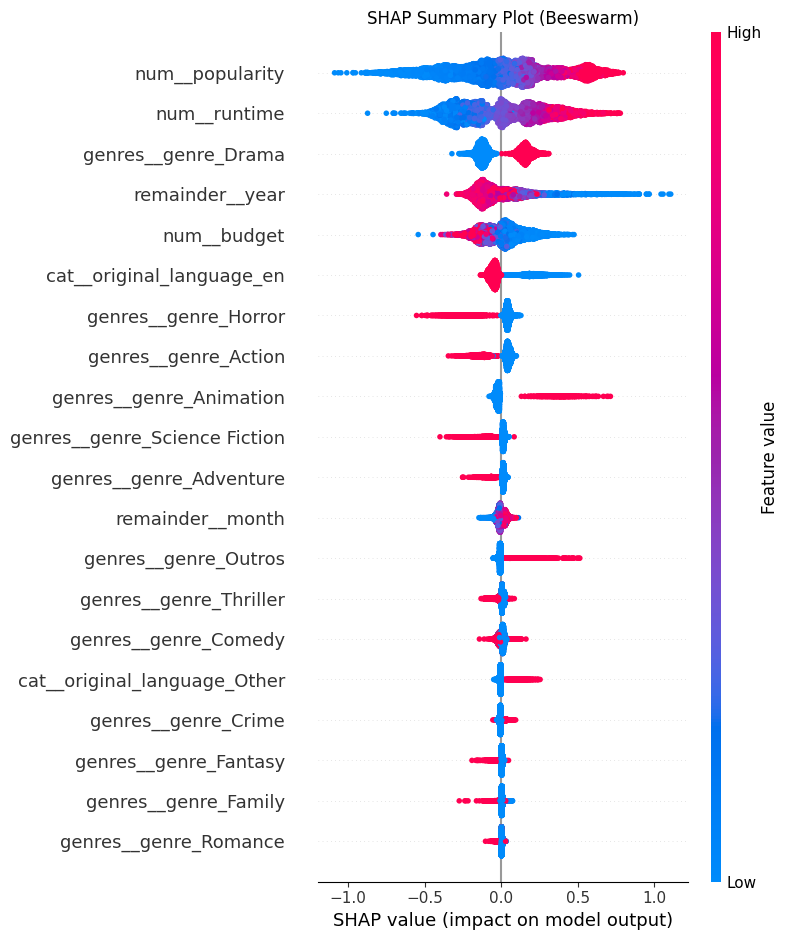

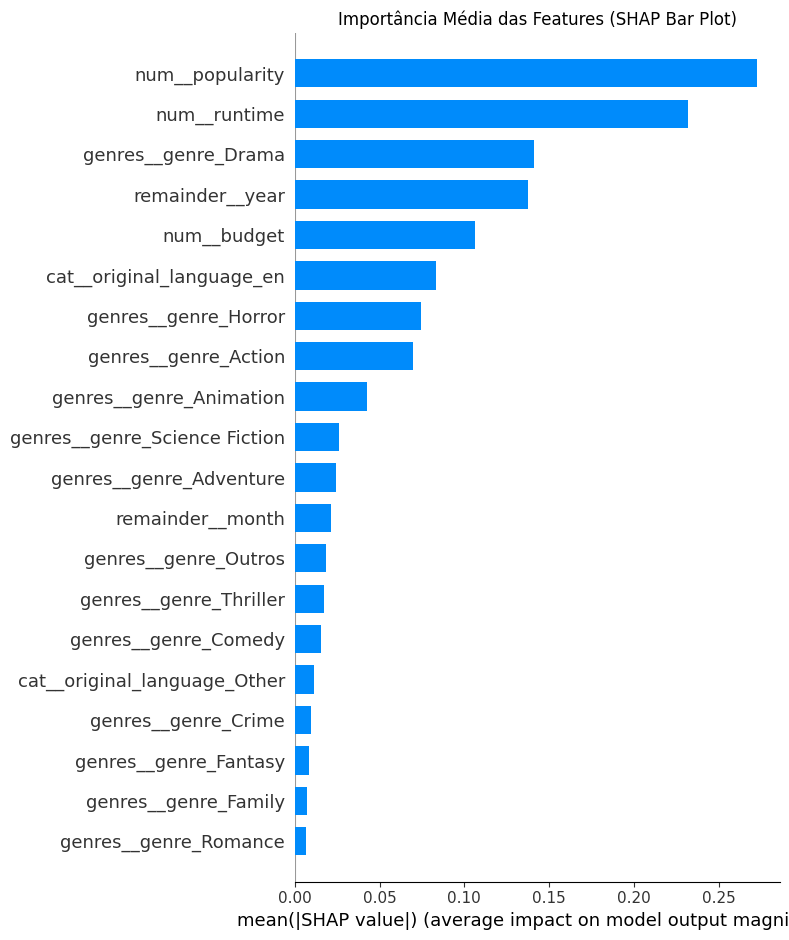

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline # Importe o Pipeline

# --- Assumindo que seu código de treinamento já foi executado ---
# XGBRegressor_rand.fit(X_train, y_train)

# 1. Obter o melhor pipeline treinado
best_pipeline = XGBRegressor_rand.best_estimator_

# 2. Criar um pipeline APENAS com os passos de pré-processamento
#    Isso garante que 'DateFeatureExtractor' rode antes do 'ColumnTransformer'.
#    O 'steps[:-1]' pega todos os passos, exceto o último (o regressor).
preprocessing_pipeline = Pipeline(best_pipeline.steps[:-1])

# Agora, transforme os dados usando este pipeline de pré-processamento completo
X_train_transformed = preprocessing_pipeline.transform(X_train)


# 3. Obter os nomes das features do ColumnTransformer (que é o passo 'preprocess')
#    O método get_feature_names_out() do ColumnTransformer inclui as colunas do 'remainder=passthrough'
col_transformer = best_pipeline.named_steps['preprocess']
feature_names = col_transformer.get_feature_names_out()


# 4. Criar um DataFrame com os dados transformados para melhor visualização no SHAP
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


# 5. Extrair o modelo final e calcular os valores SHAP
xgb_model = best_pipeline.named_steps['regressor']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_train_transformed_df) # A API moderna do SHAP usa o explainer como uma função

print("Valores SHAP calculados com sucesso. Gerando gráficos...")

# 6. Gerar os gráficos
plt.figure()
plt.title("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_train_transformed_df, show=False)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

plt.figure()
plt.title("Importância Média das Features (SHAP Bar Plot)")
shap.summary_plot(shap_values, X_train_transformed_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

## Importance

In [ ]:
feature_importance = np.abs(shap_values.values).mean(axis=0)
# 2. Crie o DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': feature_importance
})

# 3. Ordene o DataFrame pela coluna 'SHAP Importance' do maior para o menor
sorted_importance_df = importance_df.sort_values(
    by='SHAP Importance', 
    ascending=False
).reset_index(drop=True)

# 4. Exiba o DataFrame resultante
print("Ranking de Importância das Features (baseado em SHAP):")
# Usar to_string() para garantir que todas as linhas sejam exibidas
pd.set_option('display.max_rows', None)
print(len(sorted_importance_df))
display(sorted_importance_df)  # Use display para melhor visualização no Jupyter

Ranking de Importância das Features (baseado em SHAP):
134


,Feature,SHAP Importance
0,num__popularity,0.272584
1,num__runtime,0.231955
2,genres__genre_Drama,0.141367
3,remainder__year,0.137688
4,num__budget,0.106548
5,cat__original_language_en,0.083400
6,genres__genre_Horror,0.074464
7,genres__genre_Action,0.069739
8,genres__genre_Animation,0.042365
9,genres__genre_Science Fiction,0.026327


# Gerando Pickle

In [ ]:
'''
with open(best_model.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_rand, f)

with open('svr_pipeline.pkl', 'wb') as f:
    pickle.dump(svm_rand, f)

with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(rf_rand, f)
'''

"\nwith open('xgb_pipeline.pkl', 'wb') as f:\n    pickle.dump(XGBRegressor_rand, f)\n\nwith open('svr_pipeline.pkl', 'wb') as f:\n    pickle.dump(svm_rand, f)\n\nwith open('rf_pipeline.pkl', 'wb') as f:\n    pickle.dump(rf_rand, f)\n"